In [1]:
import librosa
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import soundfile as sf
from collections import defaultdict
from python_speech_features import logfbank,mfcc
from utils import *
import numpy as np
from sklearn.manifold import TSNE
from CQCC.cqcc import cqcc
from transformers import AutoFeatureExtractor, WavLMForXVector
import torch
import ipywidgets as widgets

In [5]:
path="../Data/PA_CSV/data.csv"

In [6]:
data=pd.read_csv(path)

In [7]:
systems=data["system_id"].value_counts().index[1:]

In [8]:
data[data['system_id'].isin(systems)].groupby('speaker_id')['system_id'].unique()

speaker_id
PA_0001    [CA, AA, CC, BC, BA, BB, AC, AB, CB]
PA_0002    [AB, AC, AA, CA, CB, BB, BA, CC, BC]
PA_0003    [CA, AA, CB, AB, AC, BC, CC, BB, BA]
PA_0004    [AB, AC, AA, CC, BA, BB, BC, CB, CA]
PA_0005    [AA, BC, CC, BA, BB, CB, CA, AB, AC]
                           ...                 
PA_0094    [AA, AB, AC, BA, BB, BC, CA, CB, CC]
PA_0095    [AA, AB, AC, BA, BB, BC, CA, CB, CC]
PA_0096    [AA, AB, AC, BA, BB, BC, CA, CB, CC]
PA_0097    [AA, AB, AC, BA, BB, BC, CA, CB, CC]
PA_0098    [AA, AB, AC, BA, BB, BC, CA, CB, CC]
Name: system_id, Length: 78, dtype: object

## Eval Systems

In [9]:
audio_bonafide_path=data[(data["speaker_id"]=="PA_0001")&(data['class_name']=="bonafide")]['filepath'].iloc[0]
audio_spoof_data = data[(data["speaker_id"] == "PA_0001") & (data['class_name'] == "spoof")]
grouped_data = audio_spoof_data.groupby('system_id')['filepath'].first()
audio_spoof_path = grouped_data.to_dict()

In [10]:
audio_bonafide_path

'../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000074.flac'

In [11]:
signal,rate=sf.read(audio_bonafide_path)
ipd.Audio(signal,rate=rate)

In [12]:
audio_spoof_path

{'AA': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000112.flac',
 'AB': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000822.flac',
 'AC': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000792.flac',
 'BA': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000504.flac',
 'BB': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000722.flac',
 'BC': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000411.flac',
 'CA': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000012.flac',
 'CB': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000967.flac',
 'CC': '../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000143.flac'}

In [13]:
for system_id, filepath in audio_spoof_path.items():
        print(f"System ID: {system_id}")
        signal,rate=sf.read(filepath)
        audio_widget = ipd.Audio(signal,rate=rate)
        display(audio_widget)

System ID: AA


System ID: AB


System ID: AC


System ID: BA


System ID: BB


System ID: BC


System ID: CA


System ID: CB


System ID: CC


In [18]:
# output_dir = "../Data/differential_mfcc_plots"
# mfccs,cqccs=process_audio_files(audio_spoof_path, audio_bonafide_path, output_dir)

In [20]:
def compute_correlation_matrix(features):
    feature_matrix = np.concatenate([features[key] for key in features], axis=1)
    correlation_matrix = np.corrcoef(feature_matrix.T)
    return correlation_matrix

def plot_correlation_matrix(features, feature_type):
    correlation_matrix=compute_correlation_matrix(features)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=range(1, correlation_matrix.shape[0]+1), yticklabels=range(1, correlation_matrix.shape[0]+1))
    plt.title(f'Correlation Matrix for {feature_type}')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()
    plt.savefig()
# plot_correlation_matrix(mfccs,"mfccs")

In [21]:
# plot_correlation_matrix(cqccs,"cqccs")

In [38]:
def get_tsne_embeddings(features, perplexity, iteration, n_components=2):
    embedding = TSNE(n_components=n_components,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    return embedding

   

def compute_and_plot_tsne(mfccs, cqccs, perplexity=50, iteration=5000, n_components=2, output_dir=None):
    # Generate a color map for keys
    color_map = plt.cm.rainbow(np.linspace(0, 1, len(mfccs) + len(cqccs)))
    # Plot MFCCs
    if n_components==3:
        plt.ion()
        ax = plt.axes(projection='3d')
    for i, (key, feature) in enumerate(mfccs.items()):
        embedding = get_tsne_embeddings(feature.T, perplexity=perplexity, iteration=iteration, n_components=n_components)
        if embedding.shape[1] == 2:
            plt.scatter(embedding[:, 0], embedding[:, 1], label=key, color=color_map[i])
        elif embedding.shape[1] == 3:
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=key, color=color_map[i])

    plt.legend()
    plt.title('t-SNE Embeddings for MFCCs')
    plt.grid(False)
    plt.figure(figsize=(15, 10)) # Set a larger figure size
    output_path = os.path.join(output_dir, f't-SNE Embeddings for MFCC.png')
    plt.savefig(output_path)
    plt.show()

    # Plot CQCCs
    if n_components==3:
        plt.ion()
        ax = plt.axes(projection='3d')
    for i, (key, feature) in enumerate(cqccs.items()):
        embedding = get_tsne_embeddings(feature, perplexity=perplexity, iteration=iteration, n_components=n_components)
        if embedding.shape[1] == 2:
            plt.scatter(embedding[:, 0], embedding[:, 1], label=key, color=color_map[i])
        elif embedding.shape[1] == 3:
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=key, color=color_map[i])

    plt.legend()
    plt.title('t-SNE Embeddings for CQCC')
    plt.grid(False)
    plt.figure(figsize=(15, 10))  # Set a larger figure size
    output_path = os.path.join(output_dir, f't-SNE Embeddings for CQCC.png')
    plt.savefig(output_path)
    plt.show()


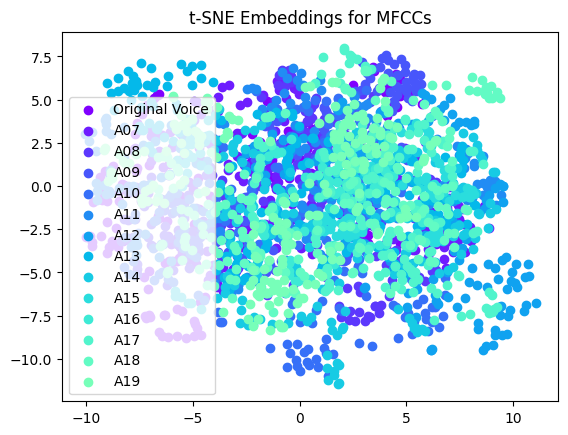

<Figure size 1500x1000 with 0 Axes>

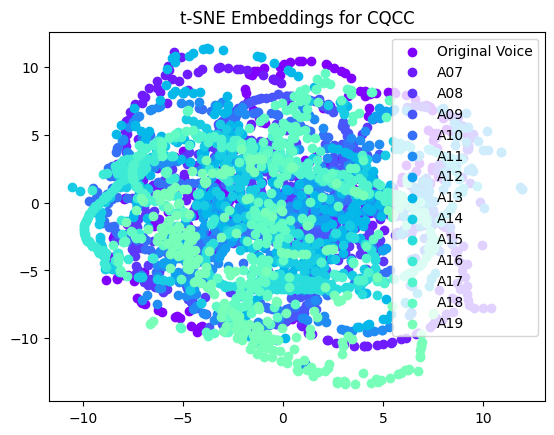

<Figure size 1500x1000 with 0 Axes>

In [39]:
perplexity = 50
iteration = 5000
compute_and_plot_tsne(mfccs,cqccs,iteration=iteration,perplexity=perplexity,output_dir=output_dir)

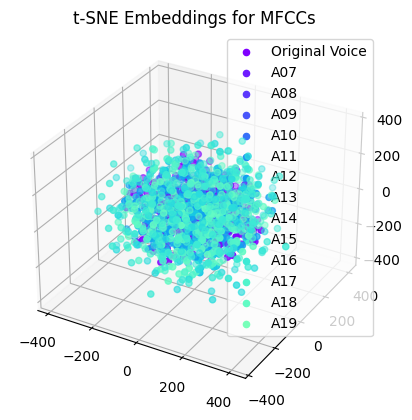

<Figure size 1500x1000 with 0 Axes>

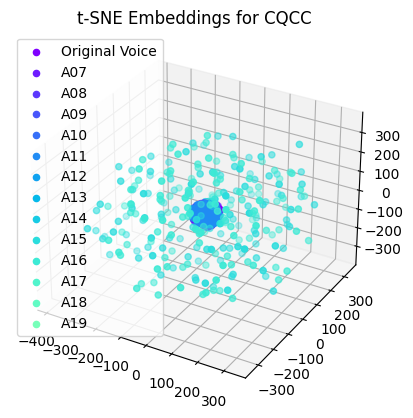

<Figure size 1500x1000 with 0 Axes>

In [40]:
perplexity = 50
iteration = 5000
compute_and_plot_tsne(mfccs,cqccs,iteration=iteration,perplexity=perplexity,n_components=3,output_dir=output_dir)

## Train and Dev Systems

In [23]:
audio_bonafide_path=data[(data["speaker_id"]=="PA_0079")&(data['class_name']=="bonafide")]['filepath'].iloc[0]
audio_spoof_data = data[(data["speaker_id"] == "PA_0079") & (data['class_name'] == "spoof")]
grouped_data = audio_spoof_data.groupby('system_id')['filepath'].first()
audio_spoof_path = grouped_data.to_dict()

In [24]:
audio_bonafide_path

'../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0000002.flac'

In [25]:
signal,rate=sf.read(audio_bonafide_path)
ipd.Audio(signal,rate=rate)

In [26]:
audio_spoof_path

{'AA': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0005401.flac',
 'AB': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0005805.flac',
 'AC': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0006209.flac',
 'BA': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0006613.flac',
 'BB': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0006693.flac',
 'BC': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0006773.flac',
 'CA': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0006853.flac',
 'CB': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0006969.flac',
 'CC': '../Data/PA/ASVspoof2019_PA_train/flac/PA_T_0007085.flac'}

In [27]:
for system_id, filepath in audio_spoof_path.items():
        print(f"System ID: {system_id}")
        signal,rate=sf.read(filepath)
        audio_widget = ipd.Audio(signal,rate=rate)
        display(audio_widget)

System ID: AA


System ID: AB


System ID: AC


System ID: BA


System ID: BB


System ID: BC


System ID: CA


System ID: CB


System ID: CC


In [ ]:
output_dir = "../Data/differential_mfcc_plots"
mfccs,cqccs=process_audio_files(audio_spoof_path, audio_bonafide_path, output_dir)

In [ ]:
import seaborn as sns
def compute_correlation_matrix(features):
    feature_matrix = np.concatenate([features[key] for key in features], axis=1)
    correlation_matrix = np.corrcoef(feature_matrix.T)
    return correlation_matrix

def plot_correlation_matrix(features, feature_type):
    correlation_matrix=compute_correlation_matrix(features)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=range(1, correlation_matrix.shape[0]+1), yticklabels=range(1, correlation_matrix.shape[0]+1))
    plt.title(f'Correlation Matrix for {feature_type}')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()
    plt.savefig()
plot_correlation_matrix(mfccs,"mfccs")

In [ ]:
plot_correlation_matrix(cqccs,"cqccs")

In [52]:
def get_tsne_embeddings(features, perplexity, iteration, n_components=2):
    embedding = TSNE(n_components=n_components,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    return embedding

   

def compute_and_plot_tsne(mfccs, cqccs, perplexity=50, iteration=5000, n_components=2, output_dir=None):
    # Generate a color map for keys
    color_map = plt.cm.rainbow(np.linspace(0, 1, len(mfccs) + len(cqccs)))
    # Plot MFCCs
    if n_components==3:
        plt.ion()
        ax = plt.axes(projection='3d')
    for i, (key, feature) in enumerate(mfccs.items()):
        embedding = get_tsne_embeddings(feature.T, perplexity=perplexity, iteration=iteration, n_components=n_components)
        if embedding.shape[1] == 2:
            plt.scatter(embedding[:, 0], embedding[:, 1], label=key, color=color_map[i])
        elif embedding.shape[1] == 3:
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=key, color=color_map[i])

    plt.legend()
    plt.title('t-SNE Embeddings for MFCCs')
    plt.figure(figsize=(15, 10)) # Set a larger figure size
    output_path = os.path.join(output_dir, f't-SNE Embeddings for MFCC.png')
    plt.savefig(output_path)
    plt.show()

    # Plot CQCCs
    if n_components==3:
        plt.ion()
        ax = plt.axes(projection='3d')
    for i, (key, feature) in enumerate(cqccs.items()):
        embedding = get_tsne_embeddings(feature, perplexity=perplexity, iteration=iteration, n_components=n_components)
        if embedding.shape[1] == 2:
            plt.scatter(embedding[:, 0], embedding[:, 1], label=key, color=color_map[i])
        elif embedding.shape[1] == 3:
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=key, color=color_map[i])

    plt.legend()
    plt.title('t-SNE Embeddings for CQCC')
    plt.figure(figsize=(15, 10))  # Set a larger figure size
    output_path = os.path.join(output_dir, f't-SNE Embeddings for CQCC.png')
    plt.savefig(output_path)
    plt.show()

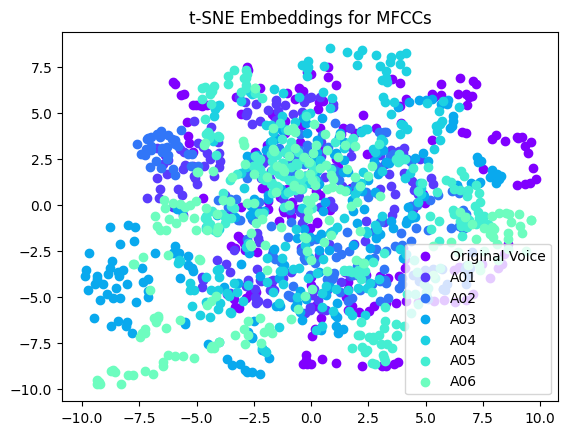

<Figure size 1000x800 with 0 Axes>

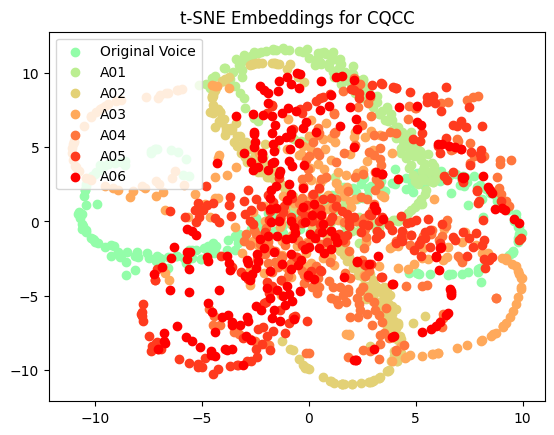

<Figure size 1000x800 with 0 Axes>

In [49]:
perplexity = 50
iteration = 5000
compute_and_plot_tsne(mfccs,cqccs,iteration=iteration,perplexity=perplexity,output_dir=output_dir)

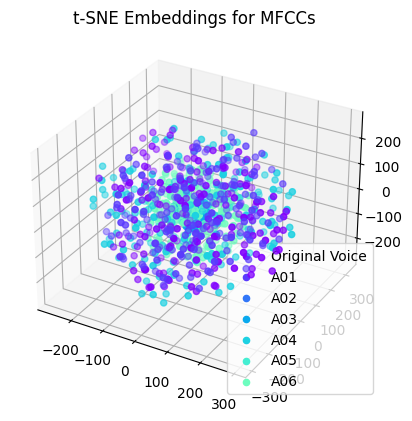

<Figure size 1500x1000 with 0 Axes>

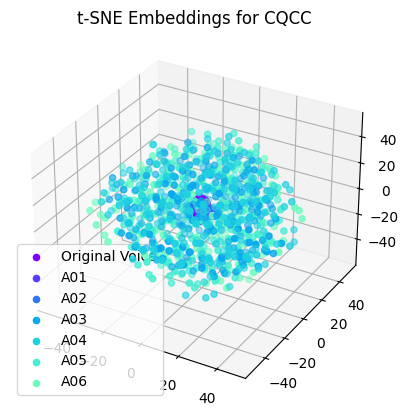

<Figure size 1500x1000 with 0 Axes>

In [53]:
perplexity = 50
iteration = 5000
compute_and_plot_tsne(mfccs,cqccs,iteration=iteration,perplexity=perplexity,n_components=3,output_dir=output_dir)

MFCCS for Random Samples 

In [54]:
bonafide_samples = data[data['class_name'] == "bonafide"]["filepath"]
random_bonafide_samples = bonafide_samples.sample(n=200, random_state=42)
system_ids = data["system_id"].value_counts().index[1:]
random_samples = {}
random_samples["bonafide"]=random_bonafide_samples
grouped_data = data.groupby("system_id")
# Iterate over each group
for system_id, group in grouped_data:
    # Check if the system_id is in the filtered system IDs
    if system_id in system_ids:
        # Randomly sample 200 file paths from the group
        sampled_paths = group['filepath'].sample(n=200, random_state=42).tolist()
        random_samples[system_id] = sampled_paths

In [72]:
import soundfile as sf
import numpy as np

def compute_embedding_feats(feature_sequence):
    stddev_features = np.std(feature_sequence, axis=0)
    mean_features = np.mean(feature_sequence, axis=0)

    average_difference_features = np.zeros((feature_sequence.shape[1],))
    for i in range(0, len(feature_sequence) - 2, 2):
        average_difference_features += feature_sequence[i] - feature_sequence[i+1]

    concat_features = np.hstack((stddev_features, mean_features, average_difference_features))
    return concat_features

def preprocess_audio_samples(samples):
    mfccs = {}
    cqccs = {}
    
    for key in samples:
        cqccs[key] = []
        mfccs[key] = []
    
    for key, filepaths in samples.items():
        for filepath in filepaths:
            signal, rate = sf.read(filepath)
            mask = envelope(signal, rate, 0.0005)
            signal = signal[mask]
            mel = compute_mfcc(signal, rate).T
            feat_cqcc, _, _ = extract_cqcc(signal[:2 * rate], rate)
            mfccs[key].append(compute_embedding_feats(mel))
            cqccs[key].append(compute_embedding_feats(feat_cqcc))
        mfccs[key] = np.array(mfccs[key])  # Convert to numpy array
        cqccs[key] = np.array(cqccs[key])
    return mfccs, cqccs   

In [73]:
mfccs_mean_std,cqccs_mean_std=preprocess_audio_samples(random_samples)

In [76]:
def compute_and_plot(mfccs, cqccs, perplexity=50, iteration=5000, n_components=2, output_dir=None):
    # Generate a color map for keys
    color_map = plt.cm.rainbow(np.linspace(0, 1, len(mfccs) + len(cqccs)))
    # Plot MFCCs
    if n_components==3:
        plt.ion()
        ax = plt.axes(projection='3d')
    for i, (key, feature) in enumerate(mfccs.items()):
        embedding = get_tsne_embeddings(feature, perplexity=perplexity, iteration=iteration, n_components=n_components)
        if embedding.shape[1] == 2:
            plt.scatter(embedding[:, 0], embedding[:, 1], label=key, color=color_map[i])
        elif embedding.shape[1] == 3:
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=key, color=color_map[i])

    plt.legend()
    plt.title('t-SNE Embeddings for MFCCs')
    plt.figure(figsize=(15, 10)) # Set a larger figure size
    output_path = os.path.join(output_dir, f't-SNE Embeddings for MFCC.png')
    plt.savefig(output_path)
    plt.show()

    # Plot CQCCs
    if n_components==3:
        plt.ion()
        ax = plt.axes(projection='3d')
    for i, (key, feature) in enumerate(cqccs.items()):
        embedding = get_tsne_embeddings(feature, perplexity=perplexity, iteration=iteration, n_components=n_components)
        if embedding.shape[1] == 2:
            plt.scatter(embedding[:, 0], embedding[:, 1], label=key, color=color_map[i])
        elif embedding.shape[1] == 3:
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=key, color=color_map[i])

    plt.legend()
    plt.title('t-SNE Embeddings for CQCC')
    plt.figure(figsize=(15, 10))  # Set a larger figure size
    output_path = os.path.join(output_dir, f't-SNE Embeddings for CQCC.png')
    plt.savefig(output_path)
    plt.show()

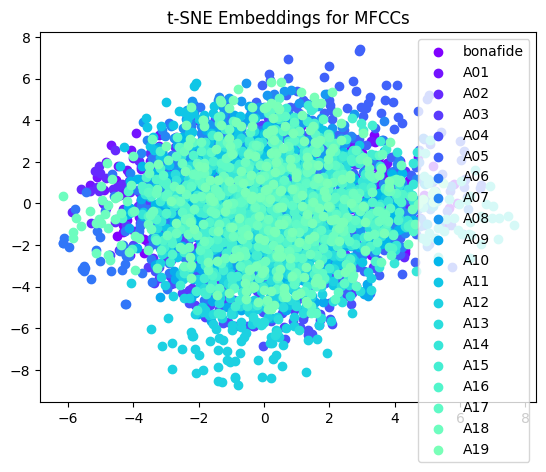

<Figure size 1500x1000 with 0 Axes>

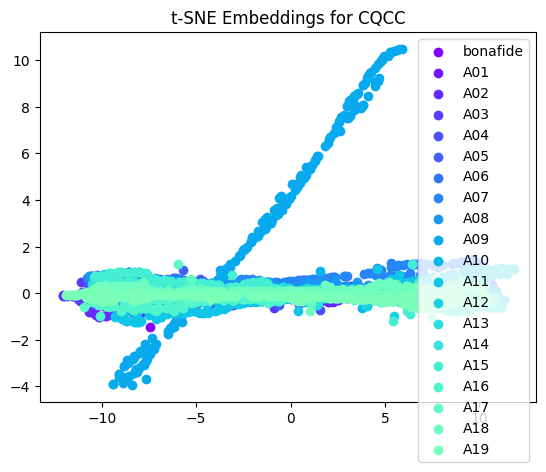

<Figure size 1500x1000 with 0 Axes>

In [77]:
perplexity = 50
iteration = 5000
compute_and_plot(mfccs_mean_std,cqccs_mean_std,iteration=iteration,perplexity=perplexity,output_dir=output_dir)

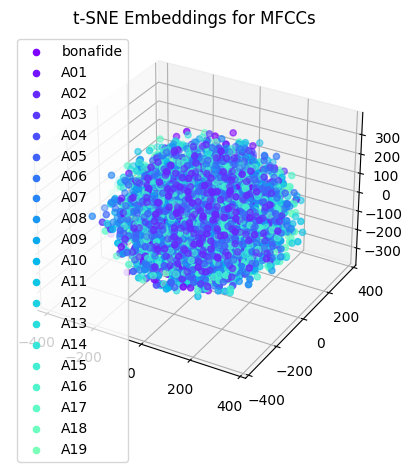

<Figure size 1500x1000 with 0 Axes>

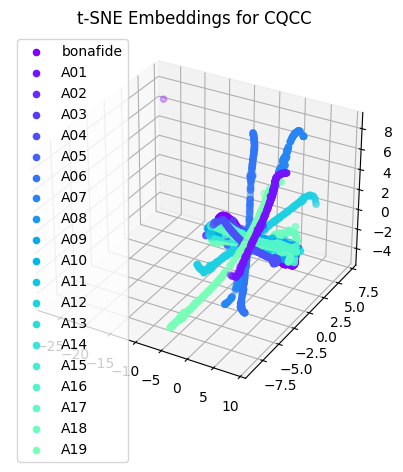

<Figure size 1500x1000 with 0 Axes>

In [78]:
perplexity = 50
iteration = 5000
compute_and_plot(mfccs_mean_std,cqccs_mean_std,iteration=iteration,perplexity=perplexity,n_components=3,output_dir=output_dir)

In [84]:
spoof_data = None  # Initialize spoof data as None
for key, matrix in mfccs_mean_std.items():
    if key != "bonafide":
        if spoof_data is None:
            matrix=matrix[:10,:]
            spoof_data = matrix.copy()
        else:
            if key!="A19":
                matrix=matrix[:10,:]
                spoof_data = np.concatenate((spoof_data, matrix), axis=0)
            else:
                 matrix=matrix[:20,:]
                 spoof_data = np.concatenate((spoof_data, matrix), axis=0)
mfccs_mean_std["spoof"]=spoof_data
spoof_data = None  # Initialize spoof data as None
for key, matrix in cqccs_mean_std.items():
    if key != "bonafide":
        if spoof_data is None:
            matrix=matrix[:10,:]
            spoof_data = matrix.copy()
        else:
            if key!="A19":
                matrix=matrix[:10,:]
                spoof_data = np.concatenate((spoof_data, matrix), axis=0)
            else:
                 matrix=matrix[:20,:]
                 spoof_data = np.concatenate((spoof_data, matrix), axis=0)
cqccs_mean_std["spoof"]=spoof_data

In [90]:
mfccs_mean_std_spoof_bonafide=mfccs_mean_std.copy()
cqccs_mean_std_spoof_bonafide=cqccs_mean_std.copy()

In [92]:
keys_to_remove = [key for key in mfccs_mean_std_spoof_bonafide.keys() if (key != "bonafide" and key != "spoof")]
for key in keys_to_remove:
    del mfccs_mean_std_spoof_bonafide[key]
keys_to_remove = [key for key in cqccs_mean_std_spoof_bonafide.keys() if (key != "bonafide" and key != "spoof")]
for key in keys_to_remove:
    del cqccs_mean_std_spoof_bonafide[key]


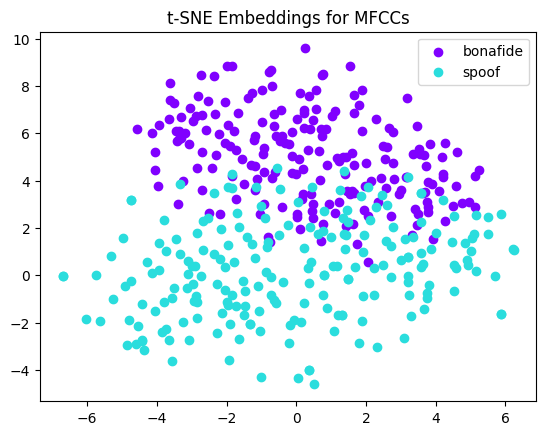

<Figure size 1500x1000 with 0 Axes>

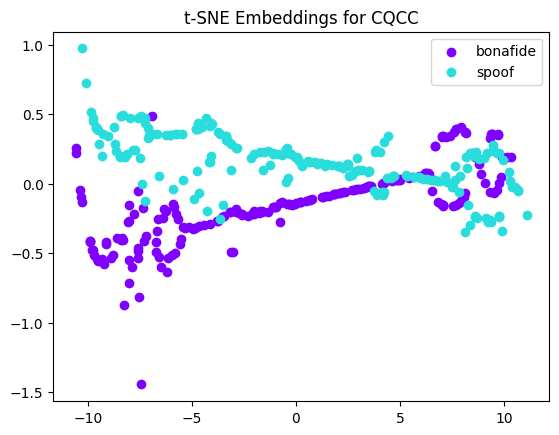

<Figure size 1500x1000 with 0 Axes>

In [93]:
perplexity = 50
iteration = 5000
compute_and_plot(mfccs_mean_std_spoof_bonafide,cqccs_mean_std_spoof_bonafide,iteration=iteration,perplexity=perplexity,output_dir=output_dir)

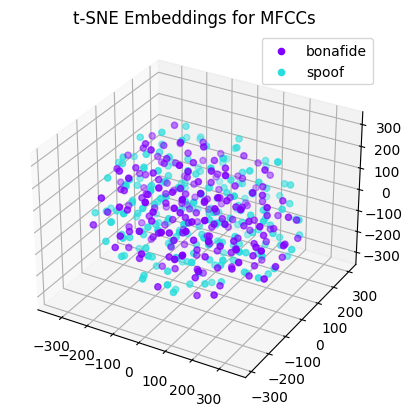

<Figure size 1500x1000 with 0 Axes>

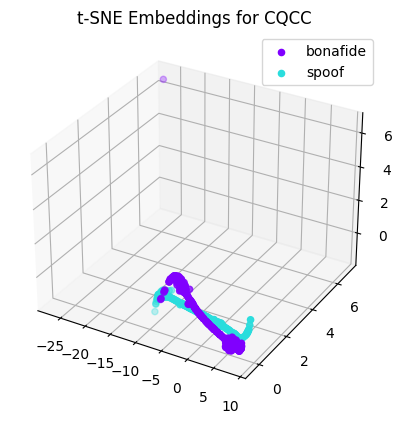

<Figure size 1500x1000 with 0 Axes>

In [95]:
perplexity = 50
iteration = 5000
compute_and_plot(mfccs_mean_std_spoof_bonafide,cqccs_mean_std_spoof_bonafide,iteration=iteration,perplexity=perplexity,n_components=3,output_dir=output_dir)